In [35]:
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import sys
sys.path.insert(0,"abetam")
from abetam.figures import sciencify_plotly_fig

def copper_result_dir(abm_result_dir: Path):
    scen_date, iteration = abm_result_dir.stem.rsplit("_",1)
    result_dirs = list(Path(f"copper/results/{scen_date}").iterdir())
    result_dirs = sorted(result_dirs)
    return result_dirs[int(iteration)]

abm_result_dirs = Path("results").iterdir()
date = "20240513"
abm_result_dirs = [d for d in abm_result_dirs if date in d.name]
# abm_result_dirs
result_df = pd.DataFrame(list([(d, copper_result_dir(d)) for d in sorted(abm_result_dirs)]), columns=["ABM path", "ESM path"])
result_df["iteration"] = result_df["ABM path"].apply( lambda p: p.stem.rsplit("_",1)[-1]).astype(int)

result_df["Scenario"] = result_df["ABM path"].apply( lambda p: p.stem.split("_",1)[0])

scen_mod = result_df["ABM path"].apply(lambda p: "+" if "_plus" in p.stem else "")

result_df["Scenario"] = result_df["Scenario"] + scen_mod

result_df

ABM path  \
0  results\BAU_20240513_0711_0   
1  results\BAU_20240513_0711_1   
2  results\BAU_20240513_0711_2   
3  results\BAU_20240513_0711_3   
4  results\BAU_20240513_0711_4   

                                            ESM path  iteration Scenario  
0  copper\results\BAU_20240513_0711\BAU_scenario_...          0      BAU  
1  copper\results\BAU_20240513_0711\BAU_scenario_...          1      BAU  
2  copper\results\BAU_20240513_0711\BAU_scenario_...          2      BAU  
3  copper\results\BAU_20240513_0711\BAU_scenario_...          3      BAU  
4  copper\results\BAU_20240513_0711\BAU_scenario_...          4      BAU

## Demand analysis

In [36]:
from main import add_abm_demand_to_projection
from abetam.batch import BatchResult


demands = []
for i,row in result_df[["ABM path", "iteration"]].iterrows():#
    abm_res_path, iteration = row["ABM path"], row["iteration"]
    b_res = BatchResult.from_directory(abm_res_path)
    model_demand = b_res.mean_carrier_demand_df
    new_demand = add_abm_demand_to_projection(model_demand)
    abm_inkl_peaks = new_demand.max().reset_index()
    abm_inkl_peaks[["province","year"]] = abm_inkl_peaks["index"].str.split(".",expand=True)
    abm_inkl_peaks = abm_inkl_peaks.rename({0:"ABM_incl"}, axis=1).drop(["index","province"],axis=1)
    abm_inkl_peaks["Demand"] = "ABM it. no: " + str(iteration)
    demands.append(abm_inkl_peaks)

abm_demands = pd.concat(demands)

In [50]:
from main import spread_model_demand

pd_demand = b_res.mean_carrier_demand_df["Electricity"].to_frame().reset_index().pivot(columns=["year"], index="hour")["Electricity"]
pd_demand.columns = [f"Ontario.{str(int(col))}" for col in pd_demand.columns]
px.line(spread_model_demand(pd_demand))

c:\Users\dhuck\miniconda3\envs\cando\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
abm_demands.columns = ["value", "year", "Demand source"]

In [ ]:
copper_demand_projection = pd.read_csv("copper/scenarios/BAU_scenario/copper_demand_user_demand=False.csv")
copper_demand_projection.columns = ["year","hour"] + copper_demand_projection.columns[2:].to_list()
copper_demand_projection["Ontario"] = copper_demand_projection["Ontario.a"] + copper_demand_projection["Ontario.b"]

copper_demand_peaks = copper_demand_projection.groupby(["year"]).max()["Ontario"].reset_index()
copper_demand_peaks = copper_demand_peaks.rename({"Ontario":"COPPER projection"}, axis=1)
copper_demand_peaks_long = copper_demand_peaks.melt(id_vars="year")
copper_demand_peaks_long.columns = ["year", "Demand source", "value"]

In [ ]:
fig = sciencify_plotly_fig(
    px.line(
        pd.concat([abm_demands, copper_demand_peaks_long]),
        x="year",
        y="value",
        color="Demand source",
        template="plotly",
    )
)
fig.update_layout(yaxis_title="Peak demand (MW)", width=400)


In [ ]:
for i,row in result_df[["ESM path", "iteration"]].iterrows():#
    esm_res_path, iteration = row["ABM path"], row["iteration"]

    abm_inkl_peaks = new_demand.max().reset_index()
    abm_inkl_peaks[["province","year"]] = abm_inkl_peaks["index"].str.split(".",expand=True)
    abm_inkl_peaks = abm_inkl_peaks.rename({0:"ABM_incl"}, axis=1).drop(["index","province"],axis=1)
    abm_inkl_peaks["Demand"] = "ABM it. no: " + str(iteration)
    demands.append(abm_inkl_peaks)

In [ ]:
from copper.phases.postprocessing import get_all_supply

supply_df = get_all_supply(result_df["ESM path"][0])
supply_df.groupby(["pds","h"]).sum().groupby("pds").max()

In [ ]:
import sys 
sys.path.insert(0,"abetam")
from abetam.batch import BatchResult
import seaborn as sns
from abetam.data.canada import (
    uncertain_demand_from_income_and_province,
    get_end_use_agg_heating_share
)
from abetam.components.model import get_income_and_attitude_weights
from abetam.components.technologies import merge_heating_techs_with_share
from abetam.batch import transform_dict_column

def get_demand_reductions(n):
    dem_red = np.random.normal(0.4875, 0.125, n)
    # ensure (0,1) boundaries
    dem_red[dem_red < 0] = -dem_red[dem_red < 0]
    dem_red[dem_red > 1] = 1 - (dem_red[dem_red > 1] - 1)
    return dem_red

def mean_energy_demand(n):
    province = "Ontario"
    price_weight_mode = 0.55
    start_year=2020
    income_distribution, weights_df = get_income_and_attitude_weights(
        n, price_weight_mode=price_weight_mode
    )
    total_energy_demand = uncertain_demand_from_income_and_province(
        income_distribution, province
    )

    province_heat_share = get_end_use_agg_heating_share(province, start_year)
    heat_demand = total_energy_demand * province_heat_share
    return heat_demand.mean()

def get_scenario_retrofit_cost(abm_res):
    no_refurbishments = abm_res.results_df[["RunId","AgentID","Refurbished","Heat demand"]].drop_duplicates().groupby("RunId")["Refurbished"].sum()
    assert no_refurbishments[0] == no_refurbishments.mean()

    mean_demand = mean_energy_demand(no_refurbishments[0])
    demand_frame = abm_res.results_df[["RunId","Step","AgentID","Heat demand"]].query("Step == 0")
    demand_frame["n_households"] = demand_frame["Heat demand"]/mean_demand
    demand_frame = demand_frame.groupby("RunId").sum()
    seeds = abm_res.results_df[["RunId","random_seed"]].drop_duplicates().set_index("RunId")
    seeds["n_households"] = demand_frame["n_households"]
    no_res_buildings = 1639581 #https://open.canada.ca/data/en/dataset/7803173f-8ab7-428c-b987-74bbde245e12/resource/6cc8a832-11d5-4d9a-9796-397905490dc1
    no_households = 5.169*1e6 # https://www.ontario.ca/page/ontario-demographic-quarterly-highlights-first-quarter

    households_per_building = no_households/no_res_buildings

    max_build_work_cost = 100000
    total_retrofit_costs = pd.DataFrame()
    refurbished_share = no_refurbishments[0]/abm_res.results_df["AgentID"].max()
    for r_id, seed, n_households in seeds.itertuples():
        # _, r_id, seed = tupl
        np.random.seed(seed)
        dem_reds = get_demand_reductions(no_refurbishments[0])

        # assume maximum reduction == maximum cost
        dem_reds /= dem_reds.max()
        retrofit_costs = (dem_reds*max_build_work_cost).mean()*no_households*refurbished_share/households_per_building
        # print(n_households/households_per_building)

        total_retrofit_costs.at[r_id,"Retrofit costs (CAD)"] = retrofit_costs

    total_retrofit_costs["scenario"] = scenario
    return total_retrofit_costs


def abm_total_ann_cost(abm_res):
    N = abm_res.results_df["N"][0]
    start_year = abm_res.results_df["start_year"][0]
    province = abm_res.results_df["province"][0]
    assert len(abm_res.results_df["province"].unique()) < 2

    # get adoption details from result
    adopt_df = abm_res.adoption_details_df.pivot(index=["RunId","year"],columns="AgentID",values="tech")

    # get starting tech distribution
    heating_techs_df = merge_heating_techs_with_share(
        start_year=start_year, province=province
    ).reset_index()
    heating_techs_df["upper_idx"] = (heating_techs_df["cum_share"] * N).astype(int)

    starting_techs = [heating_techs_df.query(f"{i}<=upper_idx")["index"].iloc[0] for i in range(500)]
    start_tech_df = pd.DataFrame([starting_techs]*6, index=pd.MultiIndex.from_product([range(6),[2020.]], names=["RunId","year"]), columns=range(500))

    # add starting tech distribution to adoption df and forward fill the dataframe
    tech_agent_map = pd.concat([adopt_df, start_tech_df]).sort_index().ffill()

    # get annual cost lookup from result
    tech_ann_cost = abm_res.results_df[["year","RunId","AgentID","Technology annual_cost"]]
    tech_ann_cost = transform_dict_column(tech_ann_cost, "Technology annual_cost", return_cols=False)
    tech_ann_cost_lookup = tech_ann_cost.melt(id_vars=["year","RunId","AgentID"], ).set_index(["year","RunId","AgentID","variable"])

    def fill_costs(col):
        # apply called on a df yields a column as param here
        col_df = col.to_frame(name="variable")
        col_df["AgentID"] = col.name
        idx = pd.Index(col_df.reset_index()[["year","RunId","AgentID","variable"]])
        return tech_ann_cost_lookup.loc[idx, "value"].values

    # swap tech names with their annual costs
    ann_cost_agent_map = tech_agent_map.apply(fill_costs)

    # reduce to full years
    is_full_year = ann_cost_agent_map.reset_index()["year"]%1==0
    ann_cost_agent_map = ann_cost_agent_map.reset_index().loc[is_full_year,:].set_index(["RunId","year"])

    # sum
    total_abm_cost = ann_cost_agent_map.groupby(["RunId"]).sum().sum(axis=1)
    return total_abm_cost.to_frame(name="agg. annual costs")


In [ ]:


tech_share_dfs = []
fuel_demands = []
subsidy_dfs = []
emission_dfs = []
lcoh_dfs = []
spendings_dfs = []
retrofit_costs = []
abm_agg_cost = []
scenario = result_df.Scenario[0]
assert len(result_df.Scenario.unique())==1
for it in result_df.iteration.unique():
    # print(scenario,":", result_df.query(f"iteration==1 and Scenario=='{scenario}'"))
    abm_res = BatchResult.from_directory(result_df.query(f"iteration=={it} and Scenario=='{result_df.Scenario[0]}'")["ABM path"].values[0])

    scenario = result_df.Scenario[0] + "_" + str(it)

    t_share_df = abm_res.tech_shares_df
    t_share_df["scenario"] = scenario
    tech_share_dfs.append(t_share_df)

    demands = abm_res.mean_carrier_demand_df.copy()
    demands["scenario"] = scenario
    fuel_demands.append(demands)

    subs = abm_res.subsidies_df
    subs["scenario"] = scenario
    subsidy_dfs.append(subs)

    emiss = abm_res.emissions()
    emiss["scenario"] = scenario
    emission_dfs.append(emiss)

    lcohs = pd.DataFrame.from_records(abm_res.results_df["LCOH"])
    lcohs[['year','RunId','AgentID',"Refurbished"]] = abm_res.results_df[['year','RunId','AgentID',"Refurbished"]]
    long_lcohs = lcohs.set_index(["year","RunId","AgentID","Refurbished"]).melt(ignore_index=False).reset_index().drop("AgentID", axis=1)
    long_lcohs = long_lcohs.round(2).drop_duplicates().groupby(["year","variable"]).mean().reset_index()
    long_lcohs["scenario"] = scenario
    lcoh_dfs.append(long_lcohs)

    adopt_df = abm_res.adoption_details_df.set_index(['RunId','AgentID','year',])
    adopt_df["req. size"] = abm_res.results_df[['RunId','AgentID','year','Required heating size']].set_index(['RunId','AgentID','year']).loc[adopt_df.index,'Required heating size']
    adopt_df["Purchase cost"] = adopt_df["purchase_price"] * adopt_df["req. size"]
    total_spendings = adopt_df.groupby(["RunId", "tech"])["Purchase cost"].sum().groupby("tech").mean().reset_index()
    total_spendings["scenario"] = scenario
    spendings_dfs.append(total_spendings)

    abm_agg_annual_costs = abm_total_ann_cost(abm_res)
    abm_agg_annual_costs["scenario"] = scenario
    abm_agg_cost.append(abm_agg_annual_costs)
    retrofit_costs.append(get_scenario_retrofit_cost(abm_res))

scenario_tech_shares = pd.concat(tech_share_dfs)
scenario_fuel_demands = pd.concat(fuel_demands)
scenario_emissions = pd.concat(emission_dfs)
scenario_subsidies = pd.concat(subsidy_dfs)
scenario_lcohs = pd.concat(lcoh_dfs)
scenario_spendings = pd.concat(spendings_dfs)
scenario_retrofit_costs = pd.concat(retrofit_costs)
abm_agg_costs = pd.concat(abm_agg_cost)

scenario_retrofit_costs.head()


In [ ]:
scenario_tech_shares_long = scenario_tech_shares.melt(id_vars=["RunId","province","year","scenario"])
scenario_tech_shares_long

In [ ]:
sns.relplot(scenario_tech_shares_long, x="year",y="value", hue="variable", col="scenario", kind="line")

# Prices

In [1]:
import pandas as pd
import plotly.express as px
price_change = pd.read_csv("scenario_price_change_over_8_iterations.csv").melt(id_vars=["year","province","iteration","scenario"])
price_change

year province  iteration scenario     variable     value
0    2025  Ontario          0      BAU         HOEP  4.491538
1    2030  Ontario          0      BAU         HOEP  4.697665
2    2035  Ontario          0      BAU         HOEP  4.335510
3    2040  Ontario          0      BAU         HOEP  4.410762
4    2045  Ontario          0      BAU         HOEP  4.053961
..    ...      ...        ...      ...          ...       ...
715  2030  Ontario          7   Rapid+  final price  4.971591
716  2035  Ontario          7   Rapid+  final price  7.767559
717  2040  Ontario          7   Rapid+  final price  9.785742
718  2045  Ontario          7   Rapid+  final price  8.453966
719  2050  Ontario          7   Rapid+  final price  8.446773

[720 rows x 6 columns]

In [29]:
# price_change.drop("province",axis=1).set_index(["scenario","variable","year","iteration"]).groupby(["scenario","variable","year"]).diff().reset_index().pivot(index=["year","iteration"],columns=["scenario","variable"],values="value")
price_change.drop("province",axis=1).set_index(["scenario","variable","year","iteration"]).groupby(["scenario","variable","year"]).std().reset_index().pivot(index=["year"],columns=["scenario","variable"],values="value")

scenario       BAU                             CER                        \
variable        GA      HOEP final price        GA      HOEP final price   
year                                                                       
2025      0.080406  0.028122    0.052284  0.110591  0.038679    0.071911   
2030      0.091297  0.031931    0.059366  0.000000  0.029485    0.029485   
2035      0.137385  0.048051    0.089334  0.000000  0.014859    0.014859   
2040      0.030962  0.010829    0.020133  0.292868  0.102432    0.190437   
2045      0.061232  0.021416    0.039816  0.179300  0.062711    0.116589   
2050      0.063659  0.022265    0.041394  0.261437  0.102055    0.162694   

scenario      CER+                           Rapid                        \
variable        GA      HOEP final price        GA      HOEP final price   
year                                                                       
2025      0.068590  0.023989    0.044600  0.275476  0.096349    0.179127   
2030      0.000000  0.019963    0.019963  0.119928  0.068926    0.059480   
2035      0.031639  0.022802    0.020748  0.460719  0.161138    0.299581   
2040      0.315079  0.110200    0.204879  0.015168  0.005305    0.009863   
2045      0.185057  0.064724    0.120332  0.009128  0.003192    0.005935   
2050      0.160579  0.056163    0.104416  0.022438  0.007848    0.014590   

scenario    Rapid+                        
variable        GA      HOEP final price  
year                                      
2025      0.330825  0.115708    0.215118  
2030      0.118785  0.063217    0.067681  
2035      0.188394  0.065891    0.122502  
2040      0.034327  0.012006    0.022321  
2045      0.020132  0.007041    0.013091  
2050      0.008654  0.003027    0.005627

In [32]:
px.line(price_change, x="year",y="value", line_dash="iteration", color="variable", facet_col="scenario")

In [11]:

fig = px.box(price_change, x="year", y="value", template="plotly", facet_col="variable", color="scenario", width=600)
fig.update_layout(boxgroupgap=0.001, boxgap=0.001)

In [17]:
import sys
sys.path.insert(0,"abetam")
from abetam.figures import sciencify_plotly_fig
# all_prices = pd.read_csv("prices_240513.csv").melt(id_vars=["year","province","iteration","scenario"])
fig = sciencify_plotly_fig(px.box(price_change, x="year", y="value", color="variable", facet_col="scenario", width=800, template="plotly"))
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_layout(boxgroupgap=0.0001,boxgap=0.0001, yaxis_title="Price components (ct/kWh)")

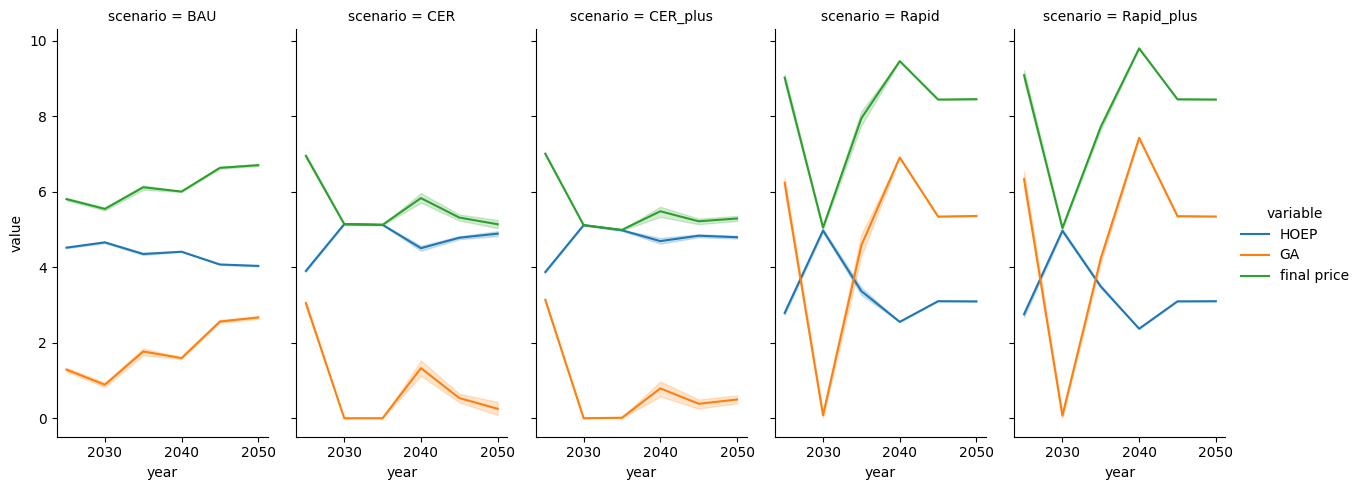

In [57]:
import seaborn as sns
sns.relplot(price_change, x="year", y="value", hue="variable", col="scenario", kind="line", height=5, aspect=0.5)